### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras import layers, losses
from sklearn import preprocessing


from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, RepeatVector, TimeDistributed, LayerNormalization, Dropout
from keras.utils import plot_model
import os

In [2]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

### Load data

In [3]:
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [5]:
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

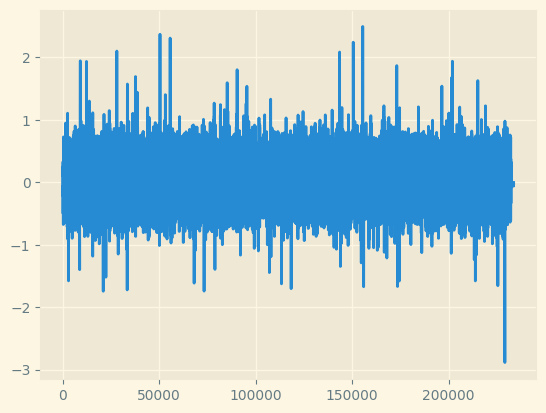

In [7]:
# data_slow one sensor
signal = data_normal[:,31]
t = [i for i in range(data_normal.shape[0])]
plt.figure(1)
plt.plot(t, signal)

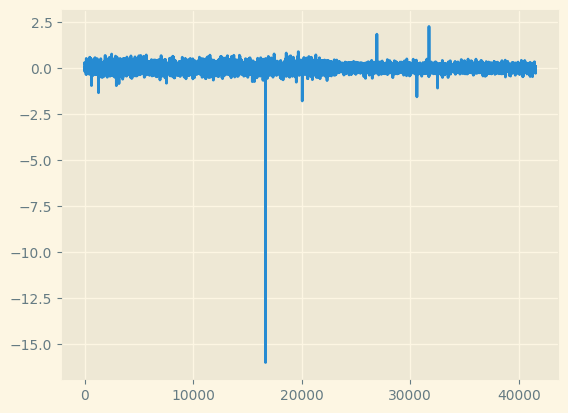

In [170]:
# data_slow one sensor
signal = data_slow[:,31]
t = [i for i in range(data_slow.shape[0])]
plt.figure(1)
plt.plot(t, signal)

## Dataset Setup

In [6]:
label_slow = data_slow[:,-1:]
data_slow = data_slow[:,:-1] # drop the last colum because it is just 1 that represents anomaly "true"

In [7]:
unique = {}
for i in range(data_normal.shape[1]):
    classes = np.unique(data_normal[:,i])
    if len(classes) < 31:
        unique[i] = [len(classes) , classes]
print(unique, len(unique))
delete_list = []
for i in range(data_normal.shape[1]):
    if i not in unique.keys():
        delete_list.append(False)
    else:
        delete_list.append(True)

{3: [5, array([49.902534, 49.951218, 50.      , 50.048878, 50.097847])], 30: [1, array([144.12])], 41: [2, array([120.3 , 144.12])], 52: [3, array([-175.86,    9.59,  144.12])], 63: [1, array([144.12])], 74: [1, array([180.24])], 85: [1, array([180.24])]} 7


In [8]:
data_normal_dr = np.delete(data_normal, delete_list, axis=1)
data_slow_dr = np.delete(data_slow, delete_list, axis=1)
print(f"Shape of slow data after basic feature selection: {data_slow_dr.shape} \nFor normal data: {data_normal_dr.shape}")

Shape of slow data after basic feature selection: (41538, 79) 
For normal data: (233792, 79)


In [9]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal_dr)
data_train_scaled = scaler.transform(data_normal_dr)
data_test_scaled = scaler.transform(data_slow_dr)

In [10]:
#windows of 48 with stride 1
width_window = 48
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])
print(f"train data shape: {data_train_all.shape} \n test data shape: {data_test_all.shape} ")

train data shape: (233744, 48, 79) 
 test data shape: (41490, 48, 79) 


In [11]:
mix_data = True
seed = 0
if mix_data:
    data_train_all = tf.random.shuffle(data_train_all)
print(f"train data shape: {data_train_all.shape} \n")

In [14]:
# First 40 percent for training, 10 percent for validation between 40-70, 10 percent for test from 70-100
percentage = 0.6
validation = [0.70, 0.80]
test = 0.85

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage*data_test_all.shape[0]),:,:]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train_all[int(test*data_train_all.shape[0]): int(test*data_train_all.shape[0])+data_test.shape[0],:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(validation[0]*data_train_all.shape[0]): int(validation[1]*data_train_all.shape[0]),:,:]


print(f"train data shape: {data_train.shape} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (140246, 48, 79) 
test data shape: (24894, 48, 79) 
label shape: (24894, 1) 

test data prepared: (49788, 48, 79) 
label prepared: (49788, 1) 

data validation: (23375, 48, 79)


## Model

In [17]:
input_shape = data_train.shape[1:]
n_features = data_train.shape[2]
latent_size = 10
batch_size = 128
dropout = False
layer_norm = True

In [18]:
class Autoencoder(Model):
  def __init__(self, encoder, decoder, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def build_model_enc():
    model = Sequential()
    model.add(LSTM(latent_size*16, activation='relu', input_shape=input_shape, return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size, activation='relu', return_sequences=False))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(RepeatVector(width_window))
    return model

def build_model_dec():
    model = Sequential()

    model.add(LSTM(latent_size, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*16, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(units=n_features)))
    return model

In [35]:
encoder = build_model_enc()
decoder = build_model_dec()

model = Autoencoder(encoder, decoder, width_window)
model.build(input_shape=(None, input_shape[0], input_shape[1]))

learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "autoencoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 48, 10)            256820    
                                                                 
 sequential_7 (Sequential)   (None, 48, 79)            219379    
                                                                 
Total params: 476,199
Trainable params: 476,199
Non-trainable params: 0
_________________________________________________________________


### Training

In [294]:
# Model 2 is the old model that saved later
model = model_2
learning_rate = 3e-6
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.build(input_shape=(None, input_shape[0], input_shape[1]))
model.summary()

Model: "autoencoder_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_64 (Sequential)  (None, 48, 8)             172752    
                                                                 
 sequential_65 (Sequential)  (None, 48, 79)            142751    
                                                                 
Total params: 315,503
Trainable params: 315,503
Non-trainable params: 0
_________________________________________________________________


In [38]:
shape = F"{latent_size}_5_layer_mixed_data"
num_epoch = 50
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{learning_rate}_{num_epoch}_{shape}"
exists = os.path.exists(model_dir)
if not exists:
    os.mkdir(model_dir)

In [39]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{model_dir}/model", verbose=1, monitor='val_loss', mode='min', save_best_only=True) #, save_freq='epoch'
history = model.fit(data_train, data_train, epochs=num_epoch, batch_size=batch_size, validation_data=(data_validation, data_validation), shuffle=False, callbacks=[cp_callback])

Epoch 1/50
1096/1096 [==============================] - ETA: 0s - loss: 0.9719
Epoch 1: val_loss improved from inf to 0.87690, saving model to /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0001_50_10_5_layer_mixed_data/model
INFO:tensorflow:Assets written to: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0001_50_10_5_layer_mixed_data/model/assets
1096/1096 [==============================] - 424s 381ms/step - loss: 0.9719 - val_loss: 0.8769
Epoch 2/50
1096/1096 [==============================] - ETA: 0s - loss: 0.7932
Epoch 2: val_loss improved from 0.87690 to 0.72709, saving model to /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0001_50_10_5_layer_mixed_data/model
INFO:tensorflow:Assets written to: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0001_50_10_5_layer_mixed_data/model/assets
1096/1096 [==============================] - 433s 395ms/step - loss: 0.7932

In [56]:
t_name = "my_boy"
os.mkdir(f"{model_dir}_{t_name}")
model.save_weights(f"{model_dir}_{t_name}/model")

In [41]:
hist_df = pd.DataFrame(history.history)

# save to json:
hist_json_file = f"{model_dir}/history.json"
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

### Reconstruction costs for train set

In [314]:
encoder_2 = build_model_enc()
decoder_2 = build_model_dec()
model_2 = Autoencoder(encoder_2, decoder_2, width_window)

In [315]:
num_epoch = 150
learning_rate = 5e-4
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{learning_rate}_{num_epoch}_{shape}"
print(model_dir)
model_2.load_weights(f"{model_dir}/model")

/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0005_150_10_5_layer


2023-06-26 20:50:51.834975: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0005_150_10_5_layer/model: FAILED_PRECONDITION: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0005_150_10_5_layer/model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


4383/4383 [==============================] - 189s 43ms/step
mean: 0.3564113523585252


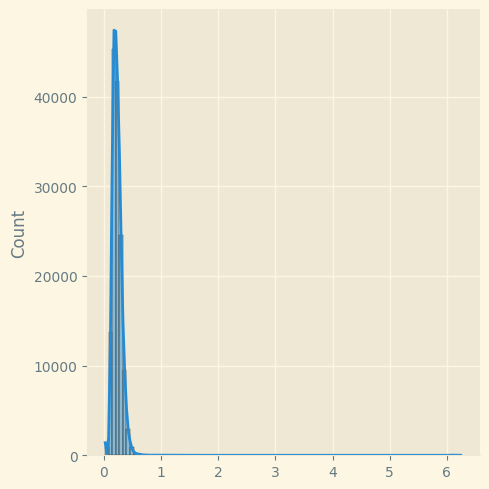

In [42]:
p_train = model.predict(data_train)

difference_train = np.abs(p_train - data_train)
print(f"mean: {np.mean(difference_train)}")

cost_train = np.mean(np.abs(p_train - data_train), axis=1)
sns.displot(cost_train[:,32], bins=100, kde=True)

### Reconstruction costs for test set

778/778 [==============================] - 33s 41ms/step
mean: 0.4375496426638879


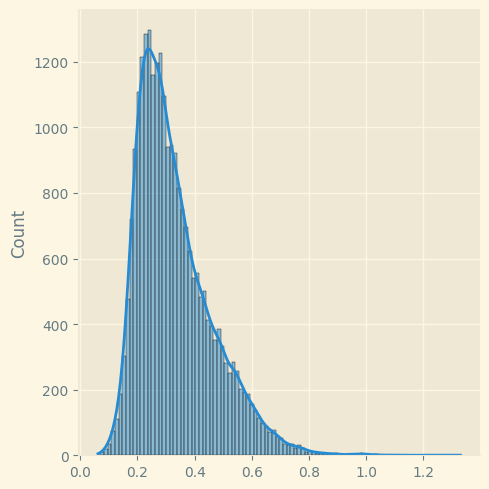

In [43]:
p_test = model.predict(data_test)

difference_test = np.abs(p_test - data_test)
print(f"mean: {np.mean(difference_test)}")

cost_test = np.mean(np.abs(p_test - data_test), axis=1)
sns.displot(cost_test[:,32], bins=100, kde=True)

### Reconstruction costs for prepared data

1556/1556 [==============================] - 68s 44ms/step
mean: 0.3974663493346585


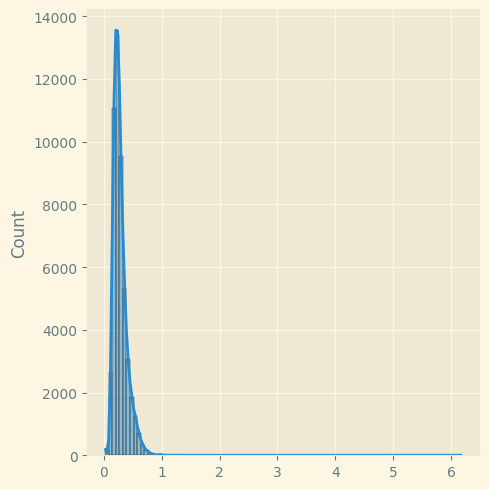

In [46]:
p_test_mixed = model.predict(data_test_mixed)

difference_test_mixed = np.abs(p_test_mixed - data_test_mixed)
print(f"mean: {np.mean(difference_test_mixed)}")

cost_test_mixed = np.mean(np.abs(p_test_mixed - data_test_mixed), axis=1)

sns.displot(cost_test_mixed[:,32], bins=100, kde=True)

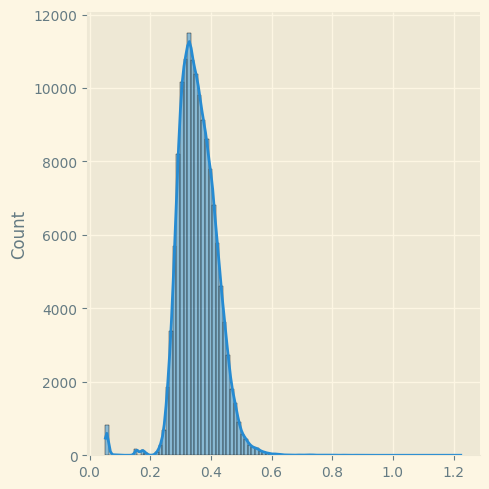

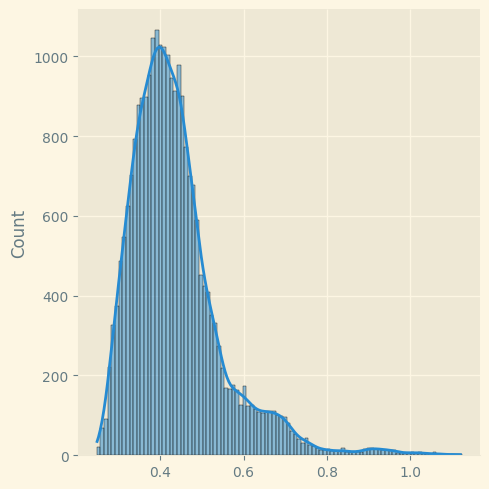

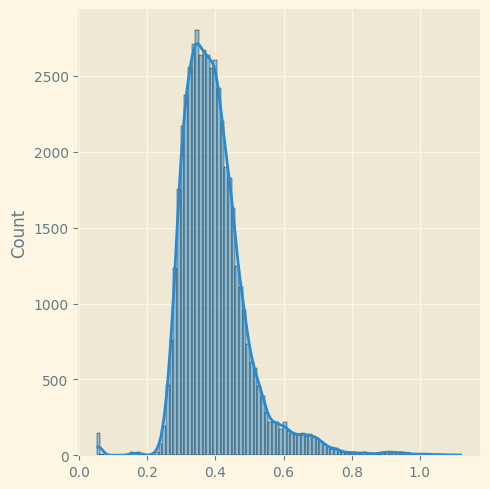

In [48]:
sns.displot(cost_train.mean(axis=1), bins=100, kde=True)
sns.displot(cost_test.mean(axis=1), bins=100, kde=True)
sns.displot(cost_test_mixed.mean(axis=1), bins=100, kde=True)

### Train - Test loss differences graph during training

In [50]:
history.history['val_loss']
last_history = history

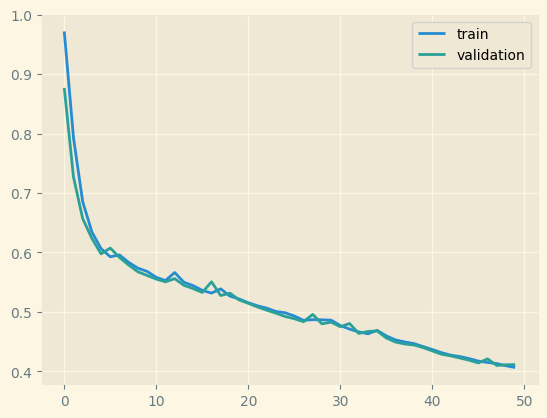

In [51]:
# since the validation loss was incredibly high in first two epoch, I visualize later then. You can change it.
plt.plot(last_history.history['loss'][0:], label="train")
plt.plot(last_history.history['val_loss'][0:], label="validation")
plt.legend()

## Evaluation Method: PA%K

In [ ]:
modified_test_label = [targets[0,int(targets.shape[0]*0.50):,:], ]

In [52]:
def pak(scores, targets, thres, k=20):
    """

    :param scores: anomaly scores
    :param targets: target labels
    :param thres: anomaly threshold
    :param k: PA%K ratio, 0 equals to conventional point adjust and 100 equals to original predictions
    :return: point_adjusted predictions
    """
    scores = np.array(scores)
    thres = np.array(thres)

    predicts = scores > thres
    actuals = targets > 0.01

    one_start_idx = np.where(np.diff(actuals, prepend=0) == 1)[0]
    zero_start_idx = np.where(np.diff(actuals, prepend=0) == -1)[0]

    assert len(one_start_idx) == len(zero_start_idx) + 1 or len(one_start_idx) == len(zero_start_idx)

    if len(one_start_idx) == len(zero_start_idx) + 1:
        zero_start_idx = np.append(zero_start_idx, len(predicts))

    for i in range(len(one_start_idx)):
        if predicts[one_start_idx[i]:zero_start_idx[i]].sum() > k / 100 * (zero_start_idx[i] - one_start_idx[i]):
            predicts[one_start_idx[i]:zero_start_idx[i]] = 1

    return predicts

In [332]:
s = [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,]
print(np.diff(s, prepend=0))

[ 1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]


In [53]:
def evaluate(scores, targets, pa=True, interval=50, k=40):
    """
    :param scores: list or np.array or tensor, anomaly score
    :param targets: list or np.array or tensor, target labels
    :param pa: True/False
    :param interval: threshold search interval
    :param k: PA%K threshold
    :return: results dictionary
    """
    assert len(scores) == len(targets)

    results = {}

    try:
        scores = np.asarray(scores)
        targets = np.asarray(targets)
    except TypeError:
        scores = np.asarray(scores.cpu())
        targets = np.asarray(targets.cpu())

    precision, recall, threshold = metrics.precision_recall_curve(targets, scores)
    f1_score = 2 * precision * recall / (precision + recall + 1e-30)

    #print(f"WITHOUT PA: \nMean precision: {np.mean(precision)} \nMean recall: {np.mean(recall)} \nMean F1 score: {np.mean(f1_score)}")

    results['best_f1_wo_pa'] = np.max(f1_score)
    results['f1_scores'] = f1_score
    results['best_precision_wo_pa'] = precision[np.argmax(f1_score)]
    results['best_recall_wo_pa'] = recall[np.argmax(f1_score)]
    results['prauc_wo_pa'] = metrics.average_precision_score(targets, scores)
    try:
        results['auc_wo_pa'] = metrics.roc_auc_score(targets, scores)
    except ValueError:
        pass


    if pa:
        # find F1 score with optimal threshold of best_f1_wo_pa
        pa_scores = pak(scores, targets, threshold[np.argmax(f1_score)], k)
        results['raw_f1_w_pa'] = metrics.f1_score(targets, pa_scores)
        results['raw_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['raw_recall_w_pa'] = metrics.recall_score(targets, pa_scores)

        # find best F1 score with varying thresholds
        if len(scores) // interval < 1:
            ths = threshold
        else:
            ths = [threshold[interval*i] for i in range(len(threshold)//interval)]
        pa_f1_scores = [metrics.f1_score(targets, pak(scores, targets, th, k)) for th in tqdm(ths)]
        pa_f1_scores = np.asarray(pa_f1_scores)
        results['best_f1_w_pa'] = np.max(pa_f1_scores)
        results['best_f1_th_w_pa'] = ths[np.argmax(pa_f1_scores)]
        pa_scores = pak(scores, targets, ths[np.argmax(pa_f1_scores)], k)
        results['best_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['best_recall_w_pa'] = metrics.recall_score(targets, pa_scores)
        results['pa_f1_scores'] = pa_f1_scores

    return results

## Mean F1 Scores for different K values


In [54]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed.ravel()

result = evaluate(scores, targets, k=50)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

result

100%|██████████| 995/995 [00:13<00:00, 76.25it/s]

mean F1 score without PA: 0.5811807589980663 
mean F1 score with PA: 0.6615819989373223


{'best_f1_wo_pa': 0.6968011803044797,
 'f1_scores': array([6.66666667e-01, 6.66675594e-01, 6.66684521e-01, ...,
        1.60668380e-04, 8.03374172e-05, 0.00000000e+00]),
 'best_precision_wo_pa': 0.5841783335598749,
 'best_recall_wo_pa': 0.8632200530248253,
 'prauc_wo_pa': 0.7622739344067642,
 'auc_wo_pa': 0.7395796838513349,
 'raw_f1_w_pa': 0.7649806404031713,
 'raw_precision_w_pa': 0.6194078128887783,
 'raw_recall_w_pa': 1.0,
 'best_f1_w_pa': 0.9243622591066059,
 'best_f1_th_w_pa': 0.4176186383009159,
 'best_precision_w_pa': 0.8593620546810273,
 'best_recall_w_pa': 1.0,
 'pa_f1_scores': array([0.66667559, 0.66712224, 0.66756949, 0.66801734, 0.66846578,
        0.66891483, 0.66936449, 0.66981475, 0.6702205 , 0.67061771,
        0.67103348, 0.67143165, 0.6718303 , 0.67216589, 0.6725745 ,
        0.6729927 , 0.67334767, 0.67367566, 0.67406786, 0.67441482,
        0.67477129, 0.67521055, 0.67558619, 0.67593473, 0.67634793,
        0.67672484, 0.67711138, 0.67746149, 0.67790425, 0.67831063

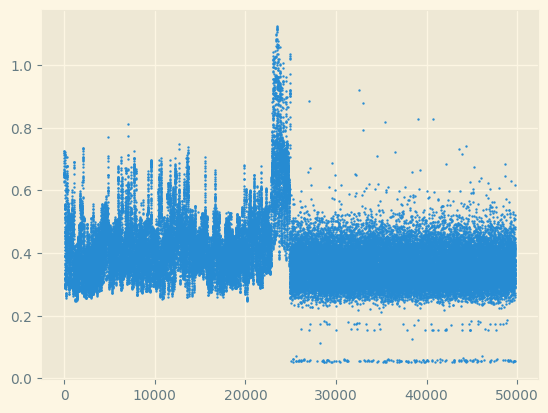

In [55]:
plt.scatter( [i for i in range(scores.shape[0])], scores, s=0.5)

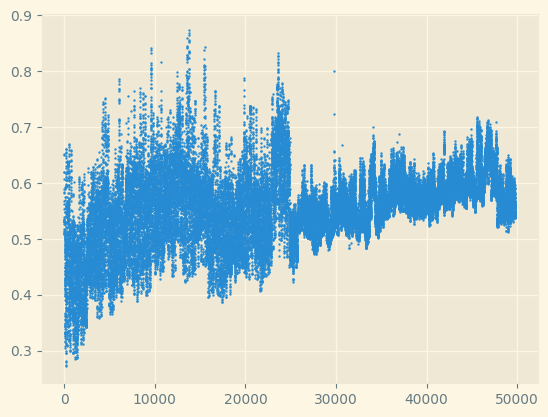

In [340]:
plt.scatter( [i for i in range(scores.shape[0])], scores, s=0.5)

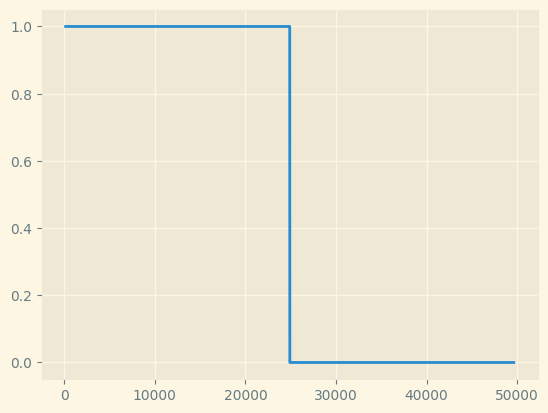

In [327]:
plt.plot(targets)

In [87]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed

result = evaluate(scores, targets, k=50)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

result

100%|██████████| 165/165 [00:04<00:00, 36.43it/s]

mean F1 score without PA: 0.7122218101275138 
mean F1 score with PA: 0.5996741128050395


{'best_f1_wo_pa': 0.9936954413191078,
 'f1_scores': array([6.66666667e-01, 6.66720244e-01, 6.66773831e-01, ...,
        9.63855422e-04, 4.82043866e-04, 0.00000000e+00]),
 'best_precision_wo_pa': 0.9995121951219512,
 'best_recall_wo_pa': 0.9879459980713597,
 'prauc_wo_pa': 0.9998997415820136,
 'auc_wo_pa': 0.999899046280858,
 'raw_f1_w_pa': 0.6667202443140722,
 'raw_precision_w_pa': 0.5000602772754672,
 'raw_recall_w_pa': 1.0,
 'best_f1_w_pa': 0.6667202443140722,
 'best_f1_th_w_pa': 0.42251794566128686,
 'best_precision_w_pa': 0.5000602772754672,
 'best_recall_w_pa': 1.0,
 'pa_f1_scores': array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667

In [58]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed.ravel()

f1_wo_pa_list_trained = []
f1_w_pa_list_trained = []

f1_wo_pa_list_trained_max = []
f1_w_pa_list_trained_max = []

k_list = [i*5 for i in range(21)]
for i in k_list:
    i = i+1 if i == 0 else i

    result = evaluate(scores, targets, k=i)

    mean_f1_wo_pa = np.mean(result["f1_scores"])
    mean_f1_w_pa = np.mean(result["pa_f1_scores"])


    f1_w_pa_list_trained.append(mean_f1_w_pa)
    f1_wo_pa_list_trained.append(mean_f1_wo_pa)

    f1_wo_pa_list_trained_max.append(np.max(result["f1_scores"]))
    f1_w_pa_list_trained_max.append(np.max(result["pa_f1_scores"]))

100%|██████████| 995/995 [00:12<00:00, 78.41it/s]


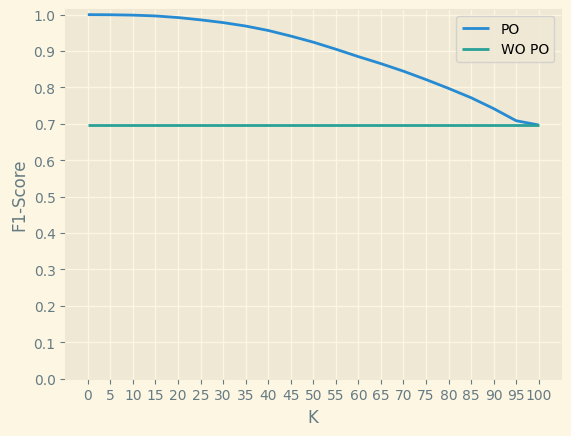

In [59]:
plt.plot(f1_w_pa_list_trained_max, label="PO")
plt.plot(f1_wo_pa_list_trained_max, label="WO PO")
plt.xticks(ticks=[i for i in range(21)],labels=k_list)
plt.yticks(ticks=[i*0.1 for i in range(11)])
plt.xlabel("K")
plt.ylabel("F1-Score")
plt.legend()

## Untrained Model

In [60]:
encoder_u = build_model_enc()
decoder_u = build_model_dec()

u_model = Autoencoder(encoder_u, decoder_u, width_window)
u_model.build(input_shape=(None, input_shape[0], input_shape[1]))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
u_model.compile(optimizer=optimizer, loss='mse')
u_model.summary()

Model: "autoencoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 48, 10)            256820    
                                                                 
 sequential_9 (Sequential)   (None, 48, 79)            219379    
                                                                 
Total params: 476,199
Trainable params: 476,199
Non-trainable params: 0
_________________________________________________________________


1556/1556 [==============================] - 67s 43ms/step
mean: 1.153231642045701


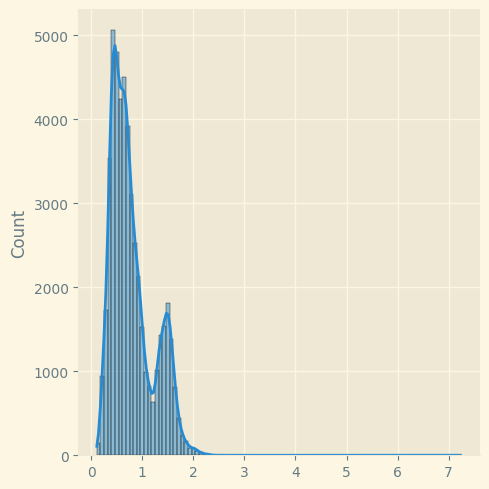

In [61]:
p_untrained = u_model.predict(data_test_mixed)

difference_untrained = np.abs(p_untrained - data_test_mixed)
print(f"mean: {np.mean(difference_untrained)}")

cost_untrained= np.mean(np.abs(p_untrained - data_test_mixed), axis=1)

sns.displot(cost_untrained[:,32], bins=100, kde=True)

In [63]:
# For random initialized un-trained model
scores = np.mean(cost_untrained, axis=1)
targets = label_test_mixed.ravel()

f1_wo_pa_list_untrained = []
f1_w_pa_list_untrained = []

f1_wo_pa_list_trained_max_untrained = []
f1_w_pa_list_trained_max_untrained = []
k_list = [i*5 for i in range(21)]
for i in k_list:
    i = i+1 if i == 0 else i

    result = evaluate(scores, targets, k=i)

    mean_f1_wo_pa = np.mean(result["f1_scores"])
    mean_f1_w_pa = np.mean(result["pa_f1_scores"])

    f1_w_pa_list_untrained.append(mean_f1_w_pa)
    f1_wo_pa_list_untrained.append(mean_f1_wo_pa)

    f1_wo_pa_list_trained_max_untrained.append(np.max(result["f1_scores"]))
    f1_w_pa_list_trained_max_untrained.append(np.max(result["pa_f1_scores"]))

100%|██████████| 995/995 [00:12<00:00, 76.55it/s]


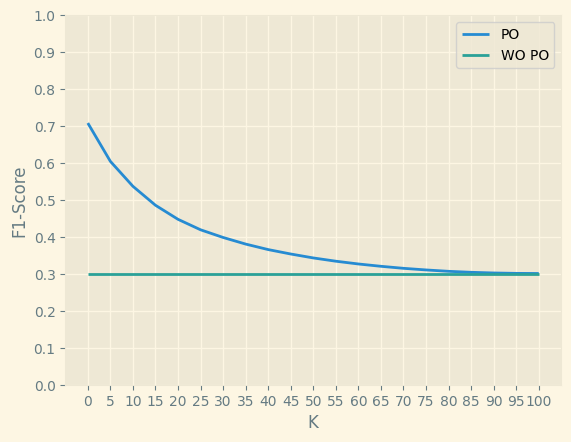

In [64]:
plt.plot(f1_w_pa_list_untrained, label="PO")
plt.plot(f1_wo_pa_list_untrained, label="WO PO")
plt.xticks(ticks=[i for i in range(21)],labels=k_list)
plt.yticks(ticks=[i*0.1 for i in range(11)])
plt.xlabel("K")
plt.ylabel("F1-Score")
plt.legend()

In [66]:
scores = np.mean(cost_test, axis=1)
targets = label_test.ravel()

result = evaluate(scores, targets, k=1)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])

print(mean_f1_wo_pa, mean_f1_w_pa)

100%|██████████| 497/497 [00:02<00:00, 165.90it/s]

0.613701071269739 0.9920595321311455


In [55]:
scores = np.mean(cost_test, axis=1)
targets = label_test.ravel()

result = evaluate(scores, targets, k=100)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])

print(mean_f1_wo_pa, mean_f1_w_pa)

100%|██████████| 414/414 [00:00<00:00, 804.59it/s]

0.6136782260640369 0.6158499519388695


In [56]:
p_untrained_test = u_model.predict(data_test)

cost_untrained_test= np.mean(np.abs(p_untrained_test - data_test), axis=1)

130/130 [==============================] - 1s 9ms/step
mean: 0.5381548575503028


In [57]:
scores = np.mean(cost_untrained_test, axis=1)
targets = label_test.ravel()

result = evaluate(scores, targets, k=1)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])

print(mean_f1_wo_pa, mean_f1_w_pa)

100%|██████████| 414/414 [00:00<00:00, 865.71it/s]

0.6136782260640369 0.9928472937086231


In [58]:
scores = np.mean(cost_untrained_test, axis=1)
targets = label_test.ravel()

result = evaluate(scores, targets, k=100)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])

print(mean_f1_wo_pa, mean_f1_w_pa)

100%|██████████| 414/414 [00:00<00:00, 811.81it/s]

0.6136782260640369 0.6158499519388695
